In [88]:
#!pip install xgboost


In [89]:
#1. Importing all necessary Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report


In [90]:
#2. Reading Data and Features and Target split
# Read the CSV file
df = pd.read_csv('Filtered_imp_with_eGFR_CKD.csv')

# Drop rows where 'CKD_stage' is NaN
df = df.dropna(subset=['CKD_stage'])

# Drop unnecessary columns from the features (X)
X = df.drop(columns=['SEQN', 'CKD_stage', 'eGFR'])

# Target variable (CKD_stage) - Subtract 1 from the CKD_stage to make it 0-indexed
y = df['CKD_stage'].astype(int) - 1  # Subtract 1 to shift to [0, 1, 2, 3, 4]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [91]:
#3.XGBoost 

from xgboost import XGBClassifier

# Initialize the XGBoost Classifier
xgb_model = XGBClassifier(
    objective='multi:softmax',  # Multi-class classification
    num_class=5,                # 5 classes (CKD stages 0 to 4)
    eval_metric='mlogloss',     # Multiclass log loss as the evaluation metric
    random_state=42
)

# Train the model
xgb_model.fit(X_train, y_train)

print("Model training completed successfully!")
# Generate predictions for the test set
y_pred_xgb = xgb_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_xgb)
print(f"Accuracy: {accuracy:.2f}")

# Generate and display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_xgb)
print("Confusion Matrix:")
print(conf_matrix)

# Generate and display the classification report
class_report = classification_report(y_test, y_pred_xgb, target_names=['Stage 1', 'Stage 2', 'Stage 3', 'Stage 4', 'Stage 5'])
print("Classification Report:")
print(class_report)

Model training completed successfully!
Accuracy: 0.96
Confusion Matrix:
[[866  10   0   0   0]
 [ 12 273   3   0   0]
 [  0  13  45   5   0]
 [  0   0   0  15   2]
 [  0   0   0   0   4]]
Classification Report:
              precision    recall  f1-score   support

     Stage 1       0.99      0.99      0.99       876
     Stage 2       0.92      0.95      0.93       288
     Stage 3       0.94      0.71      0.81        63
     Stage 4       0.75      0.88      0.81        17
     Stage 5       0.67      1.00      0.80         4

    accuracy                           0.96      1248
   macro avg       0.85      0.91      0.87      1248
weighted avg       0.96      0.96      0.96      1248



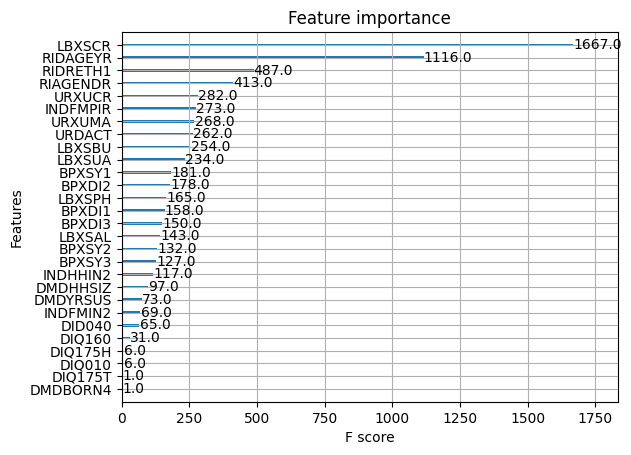

In [92]:
#4. Feature Importance 1
import xgboost as xgb

# Plot feature importance
xgb.plot_importance(xgb_model)
plt.show()


C:\Users\kvhem\AppData\Local\Temp\ipykernel_21964\226507829.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


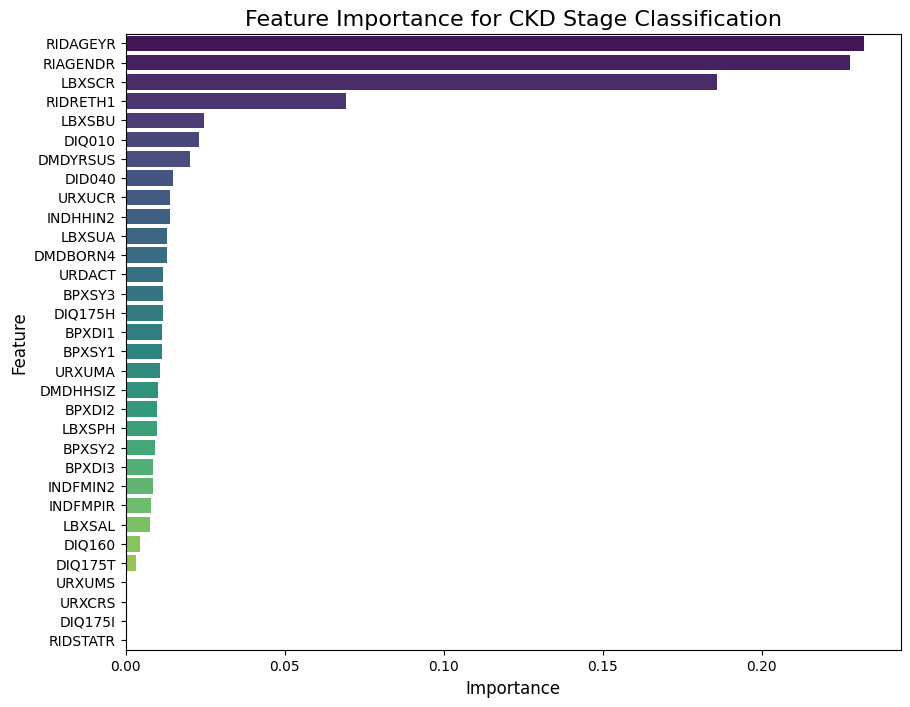

In [93]:
#Feature Importance 2

# Extract feature importance from the model
feature_importance = xgb_model.feature_importances_
features = X_train.columns

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importance
})

# Sort by importance for better visualization
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plotting
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')

plt.title('Feature Importance for CKD Stage Classification', fontsize=16)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.show()


In [94]:
#!pip install shap


<Figure size 1200x800 with 0 Axes>

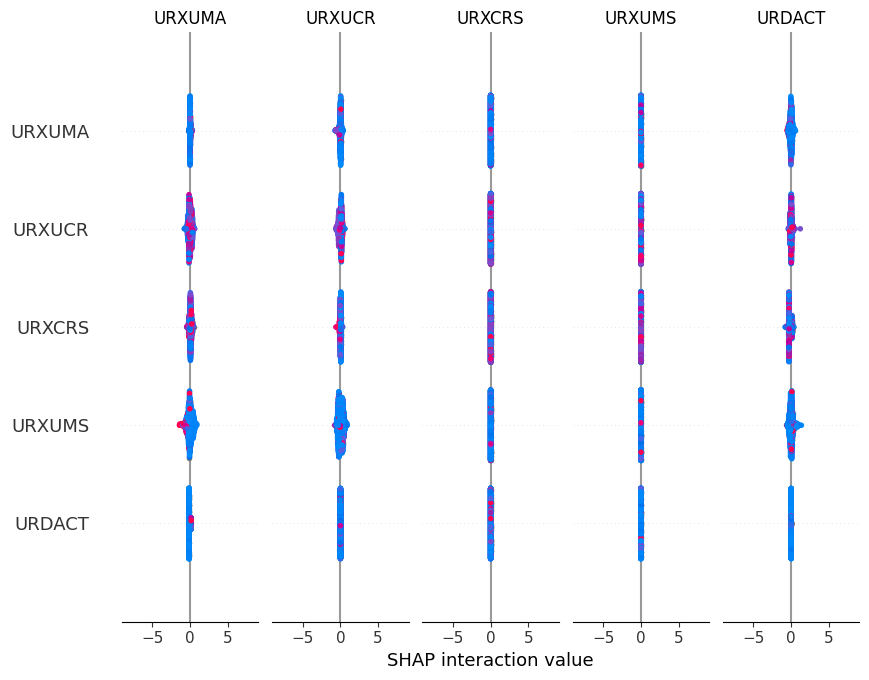

In [95]:
#5.SHAP Visualization
import shap

# Use Tree SHAP explainer for XGBoost
explainer = shap.TreeExplainer(xgb_model)

# Get SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Create a beeswarm plot to show the distribution of SHAP values for each feature
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test, plot_type='dot', feature_names=features)


In [104]:
#6.Random Forest
from sklearn.ensemble import RandomForestClassifier

# Initialize and train the Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict and evaluate
y_pred_rf = rf.predict(X_test)
print("Random Forest Model Performance:")
print(classification_report(y_test, y_pred_rf,target_names=['Stage 1', 'Stage 2', 'Stage 3', 'Stage 4', 'Stage 5']))
print("Accuracy:", accuracy_score(y_test, y_pred_rf))


Random Forest Model Performance:
              precision    recall  f1-score   support

     Stage 1       0.93      0.97      0.95       876
     Stage 2       0.77      0.77      0.77       288
     Stage 3       0.77      0.32      0.45        63
     Stage 4       0.73      0.65      0.69        17
     Stage 5       1.00      0.25      0.40         4

    accuracy                           0.89      1248
   macro avg       0.84      0.59      0.65      1248
weighted avg       0.88      0.89      0.88      1248

Accuracy: 0.8854166666666666


In [97]:
#7. For KNN and other classifiers we are handling NaN values
from sklearn.impute import SimpleImputer

# Impute missing values with the mean (or use strategy='median'/'most_frequent')
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test= imputer.transform(X_test)


In [106]:
#8.KNN
from sklearn.neighbors import KNeighborsClassifier

# Initialize and train KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Evaluate
y_pred_knn = knn.predict(X_test)
print("KNN Report:\n", classification_report(y_test, y_pred_knn,target_names=['Stage 1', 'Stage 2', 'Stage 3', 'Stage 4', 'Stage 5']))


KNN Report:
               precision    recall  f1-score   support

     Stage 1       0.75      0.92      0.83       876
     Stage 2       0.43      0.26      0.33       288
     Stage 3       1.00      0.03      0.06        63
     Stage 4       0.00      0.00      0.00        17
     Stage 5       0.00      0.00      0.00         4

    accuracy                           0.71      1248
   macro avg       0.44      0.24      0.24      1248
weighted avg       0.68      0.71      0.66      1248



C:\Users\kvhem\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\kvhem\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\kvhem\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classificati

In [99]:
#8.1 With Hyper parameter Tuning for KNN
from sklearn.neighbors import KNeighborsClassifier

param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid_search_knn = GridSearchCV(
    KNeighborsClassifier(),
    param_grid_knn,
    cv=3,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

grid_search_knn.fit(X_train, y_train)
print("Best Parameters for KNN:", grid_search_knn.best_params_)
print("Best Accuracy:", grid_search_knn.best_score_)

# Evaluate the model on test set with the best parameters
best_model = grid_search_knn.best_estimator_
y_pred_best = best_model.predict(X_test)

from sklearn.metrics import classification_report, accuracy_score

print("Accuracy with Best Model:", accuracy_score(y_test, y_pred_best))
print("Classification Report:\n", classification_report(y_test, y_pred_best,target_names=['stage1','stage2','stage3','stage4','stage5']))

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best Parameters for KNN: {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}
Best Accuracy: 0.6870993589743589
Accuracy with Best Model: 0.7211538461538461
Classification Report:
               precision    recall  f1-score   support

      stage1       0.75      0.95      0.84       876
      stage2       0.48      0.24      0.32       288
      stage3       0.50      0.02      0.03        63
      stage4       0.00      0.00      0.00        17
      stage5       0.50      0.25      0.33         4

    accuracy                           0.72      1248
   macro avg       0.45      0.29      0.30      1248
weighted avg       0.67      0.72      0.66      1248



In [105]:
#9.Grading Boosting
from sklearn.ensemble import GradientBoostingClassifier

# Initialize and train Gradient Boosting
gb = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb.fit(X_train, y_train)

# Evaluate
y_pred_gb = gb.predict(X_test)
print("Gradient Boosting Report:\n", classification_report(y_test, y_pred_gb,target_names=['Stage 1', 'Stage 2', 'Stage 3', 'Stage 4', 'Stage 5']))


Gradient Boosting Report:
               precision    recall  f1-score   support

     Stage 1       0.98      0.99      0.99       876
     Stage 2       0.91      0.92      0.92       288
     Stage 3       0.85      0.63      0.73        63
     Stage 4       0.70      0.82      0.76        17
     Stage 5       0.67      1.00      0.80         4

    accuracy                           0.95      1248
   macro avg       0.82      0.87      0.84      1248
weighted avg       0.95      0.95      0.95      1248



In [107]:
#10.Naive Bayes
from sklearn.naive_bayes import GaussianNB

# Initialize and train Naive Bayes
nb = GaussianNB()
nb.fit(X_train, y_train)

# Evaluate
y_pred_nb = nb.predict(X_test)
print("Naive Bayes Report:\n", classification_report(y_test, y_pred_nb,target_names=['Stage 1', 'Stage 2', 'Stage 3', 'Stage 4', 'Stage 5']))


Naive Bayes Report:
               precision    recall  f1-score   support

     Stage 1       0.90      0.83      0.86       876
     Stage 2       0.53      0.63      0.57       288
     Stage 3       0.42      0.40      0.41        63
     Stage 4       0.14      0.18      0.16        17
     Stage 5       0.18      0.50      0.27         4

    accuracy                           0.75      1248
   macro avg       0.43      0.51      0.45      1248
weighted avg       0.78      0.75      0.76      1248



In [108]:
#11.Voting 
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

# Define individual classifiers
xgb_clf = XGBClassifier(objective='multi:softmax', num_class=5, eval_metric='mlogloss', random_state=42)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
gb_clf = GradientBoostingClassifier(n_estimators=100, random_state=42)
knn_clf = KNeighborsClassifier(n_neighbors=5)

# Create a Voting Classifier (soft voting)
voting_clf = VotingClassifier(estimators=[
    ('xgb', xgb_clf),
    ('rf', rf_clf),
    ('gb', gb_clf),
    ('knn', knn_clf)
], voting='soft')  # Use 'hard' for majority voting

# Fit the ensemble model
voting_clf.fit(X_train, y_train)

# Evaluate
y_pred_voting = voting_clf.predict(X_test)
print("Voting Classifier Performance:")
print(classification_report(y_test, y_pred_voting,target_names=['Stage 1', 'Stage 2', 'Stage 3', 'Stage 4', 'Stage 5']))
print("Accuracy:", accuracy_score(y_test, y_pred_voting))


Voting Classifier Performance:
              precision    recall  f1-score   support

     Stage 1       0.97      0.99      0.98       876
     Stage 2       0.91      0.91      0.91       288
     Stage 3       0.97      0.62      0.76        63
     Stage 4       0.75      0.88      0.81        17
     Stage 5       0.67      1.00      0.80         4

    accuracy                           0.95      1248
   macro avg       0.85      0.88      0.85      1248
weighted avg       0.95      0.95      0.95      1248

Accuracy: 0.9535256410256411


In [109]:
#12.Stacking
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

# Meta-model
meta_model = LogisticRegression(random_state=42, max_iter=1000)

# Define individual classifiers
base_models = [
    ('xgb', xgb_clf),
    ('rf', rf_clf),
    ('gb', gb_clf),
    ('knn', knn_clf)
]

# Create Stacking Classifier
stacking_clf = StackingClassifier(estimators=base_models, final_estimator=meta_model)

# Fit the Stacking Classifier
stacking_clf.fit(X_train, y_train)

# Evaluate
y_pred_stacking = stacking_clf.predict(X_test)
print("Stacking Classifier Performance:")
print(classification_report(y_test, y_pred_stacking,target_names=['Stage 1', 'Stage 2', 'Stage 3', 'Stage 4', 'Stage 5']))
print("Accuracy:", accuracy_score(y_test, y_pred_stacking))


Stacking Classifier Performance:
              precision    recall  f1-score   support

     Stage 1       0.98      0.99      0.99       876
     Stage 2       0.92      0.93      0.93       288
     Stage 3       0.92      0.73      0.81        63
     Stage 4       0.75      0.88      0.81        17
     Stage 5       0.67      1.00      0.80         4

    accuracy                           0.96      1248
   macro avg       0.85      0.91      0.87      1248
weighted avg       0.96      0.96      0.96      1248

Accuracy: 0.9615384615384616


C:\Users\kvhem\AppData\Local\Temp\ipykernel_21964\3976529043.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Accuracy', y='Model', data=accuracy_df, palette='pastel')


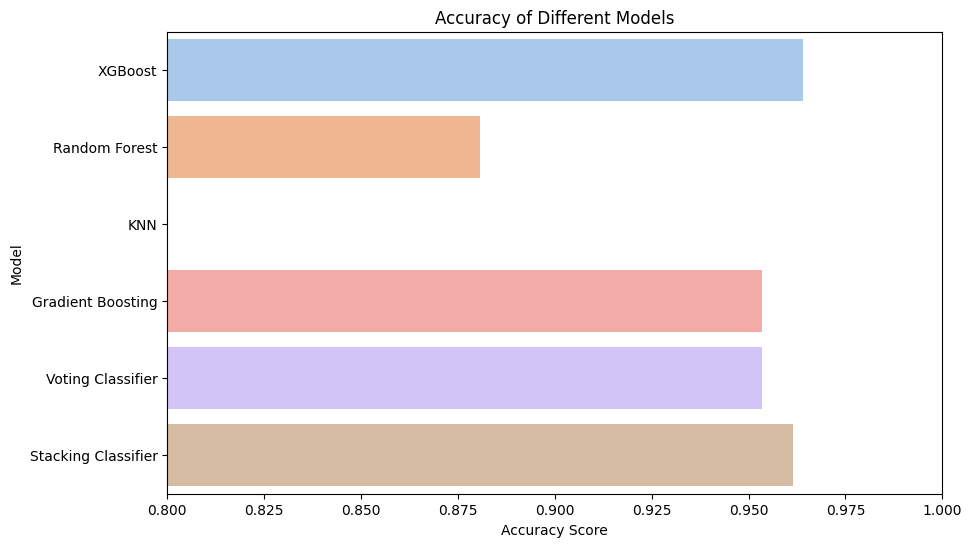

In [ ]:
#13.Model Accuracy Comparison Bar Chart

# Accuracy scores from different models
model_accuracies = {
    "XGBoost": accuracy_score(y_test, y_pred_xgb),
    "Random Forest": accuracy_score(y_test, y_pred_rf),
    "KNN": accuracy_score(y_test, y_pred_knn),
    "Gradient Boosting": accuracy_score(y_test, y_pred_gb),
    "Voting Classifier": accuracy_score(y_test, y_pred_voting),
    "Stacking Classifier": accuracy_score(y_test, y_pred_stacking)
}

# Create a DataFrame for better visualization
accuracy_df = pd.DataFrame(list(model_accuracies.items()), columns=['Model', 'Accuracy'])

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Accuracy', y='Model', data=accuracy_df, palette='pastel')
plt.title('Accuracy of Different Models')
plt.xlabel('Accuracy Score')
plt.ylabel('Model')
plt.xlim(0.8, 1.0)  # Adjust limits if needed
plt.show()


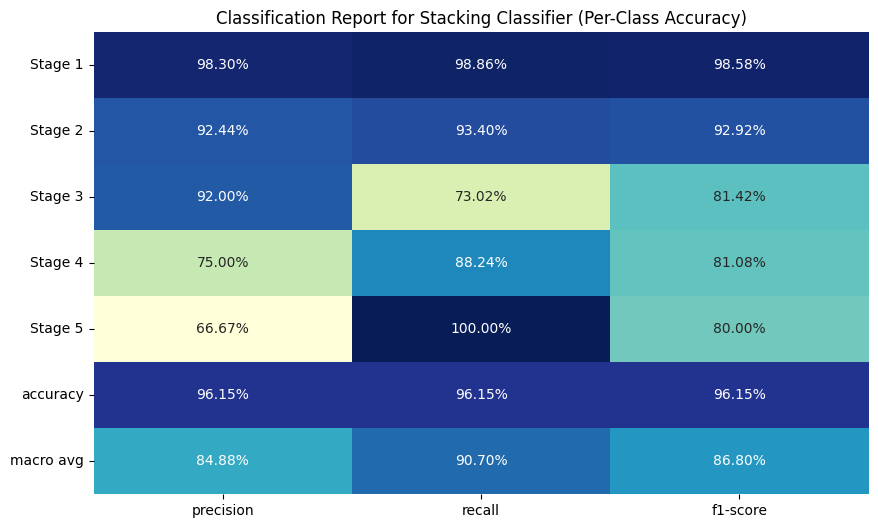

In [111]:
#14.Classification Report for Stacking Classifier

# Generate classification report as a dictionary
report = classification_report(y_test, y_pred_stacking,target_names=['Stage 1', 'Stage 2', 'Stage 3', 'Stage 4', 'Stage 5'] ,output_dict=True)

# Convert to DataFrame for visualization
report_df = pd.DataFrame(report).transpose()

# Plot heatmap for precision, recall, and F1-score for each class
plt.figure(figsize=(10, 6))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap='YlGnBu', fmt=".2%", cbar=False)
plt.title("Classification Report for Stacking Classifier (Per-Class Accuracy)")
plt.show()


C:\Users\kvhem\AppData\Local\Temp\ipykernel_21964\2811070870.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


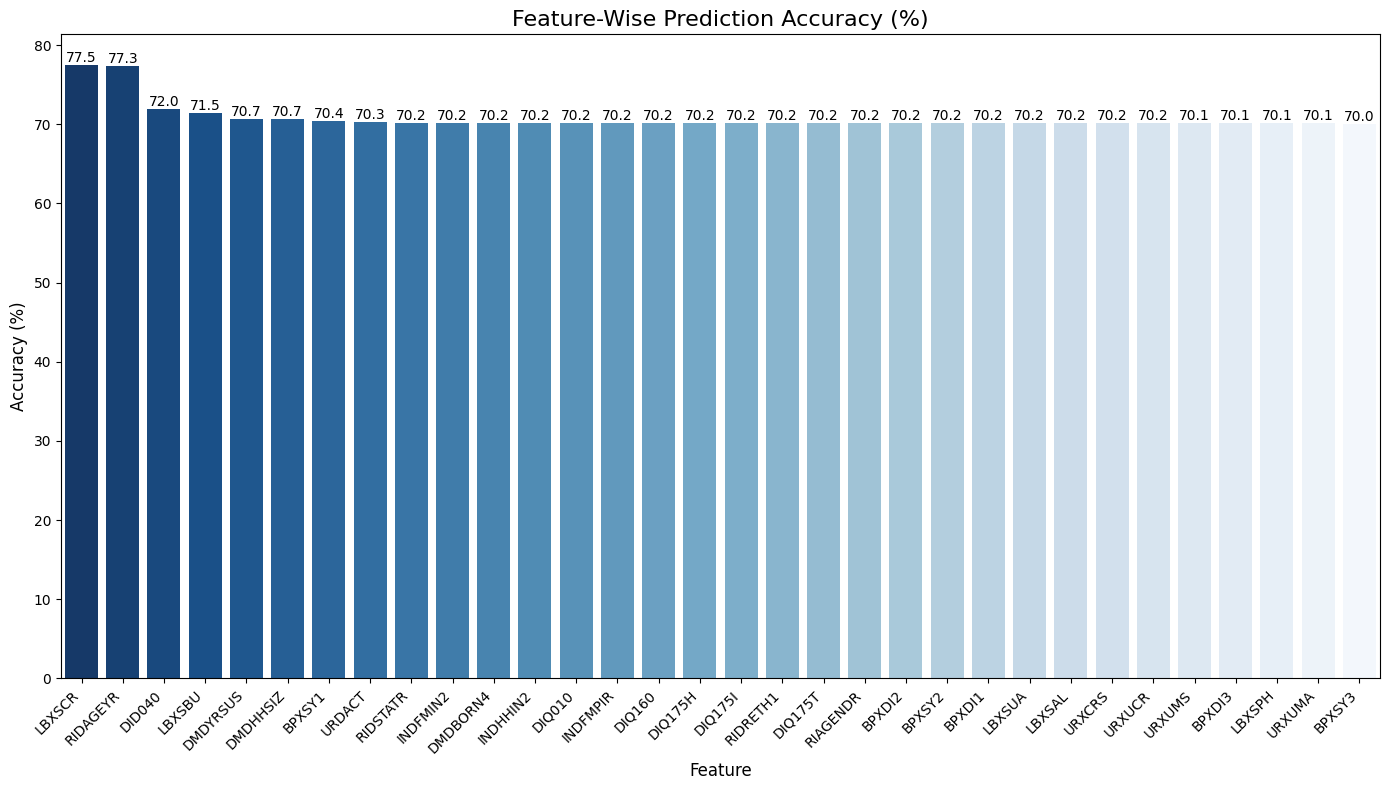

In [ ]:
#15.Individual Features Accuracies
feature_names=['URXUMA','URXUMS','URXUCR','URXCRS','URDACT', 
                     'LBXSAL','LBXSBU','LBXSCR','LBXSUA','LBXSPH',
                     'BPXSY1','BPXDI1','BPXSY2','BPXDI2','BPXSY3','BPXDI3',
                     'RIDSTATR','RIAGENDR','RIDAGEYR','RIDRETH1','DMDBORN4','DMDYRSUS','DMDHHSIZ','INDHHIN2','INDFMIN2','INDFMPIR',
                     'DIQ010','DID040','DIQ160','DIQ175H','DIQ175I','DIQ175T']

# Ensure feature names align with X_test
if X_test.shape[1] != len(feature_names):
    print(f"Mismatch detected! X_test has {X_test.shape[1]} columns, but {len(feature_names)} feature names provided.")
    feature_names = feature_names[:X_test.shape[1]]

# Convert X_train and X_test to DataFrames
X_train_df = pd.DataFrame(X_train, columns=feature_names)
X_test_df = pd.DataFrame(X_test, columns=feature_names)

feature_accuracies = {}

for feature in X_test_df.columns:
    # Use single feature for training and testing
    X_train_feature_only = X_train_df[[feature]]
    X_test_feature_only = X_test_df[[feature]]
    
    # Fit model using only the current feature
    model_feature = stacking_clf.fit(X_train_feature_only, y_train)
    
    # Predict and calculate accuracy
    y_pred_feature = model_feature.predict(X_test_feature_only)
    accuracy = (y_pred_feature == y_test).mean() * 100
    feature_accuracies[feature] = accuracy

# Visualization
feature_accuracy_df = pd.DataFrame(list(feature_accuracies.items()), columns=['Feature', 'Accuracy'])

plt.figure(figsize=(14, 8))
barplot = sns.barplot(
    x='Feature',
    y='Accuracy',
    data=feature_accuracy_df.sort_values(by='Accuracy', ascending=False),
    palette='Blues_r'  # Cool color scheme
)

# Add percentage labels on top of each bar
for bar in barplot.patches:
    barplot.annotate(
        f'{bar.get_height():.1f}',
        (bar.get_x() + bar.get_width() / 2, bar.get_height()),
        ha='center',
        va='bottom',
        fontsize=10,
        color='black'
    )

plt.title('Feature-Wise Prediction Accuracy (%)', fontsize=16)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


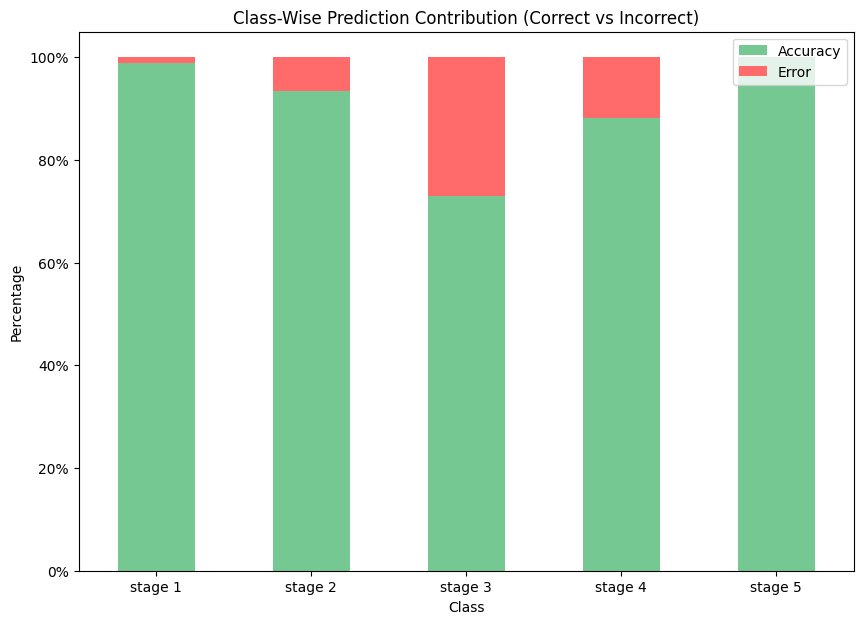

In [112]:
#16.Class wise accuracy and loss
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define the stage mapping from numeric labels to stage names
stage_mapping = {0: 'stage 1', 1: 'stage 2', 2: 'stage 3', 3: 'stage 4', 4: 'stage 5'}

# Calculate class-wise accuracy
class_accuracy = {cls: (y_pred_stacking[y_test == cls] == cls).mean() * 100 for cls in np.unique(y_test)}

# Map the numeric classes to stage names for the x-axis
class_accuracy_stage = {stage_mapping[cls]: accuracy for cls, accuracy in class_accuracy.items()}

# Create DataFrame for plotting
df_class_accuracy = pd.DataFrame.from_dict(class_accuracy_stage, orient='index', columns=['Accuracy'])

# Calculate error as 100 - accuracy
df_class_accuracy['Error'] = 100 - df_class_accuracy['Accuracy']

# Plot Stacked Bar Chart for Correct vs Incorrect Predictions
df_class_accuracy.plot(kind='bar', stacked=True, figsize=(10, 7), color=['#76c893', '#ff6b6b'])
plt.title('Class-Wise Prediction Contribution (Correct vs Incorrect)')
plt.ylabel('Percentage')
plt.xlabel('Class')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.xticks(rotation=0)

# Show the plot
plt.show()
